# Variable statistics and design experiments

In [1]:
# https://medium.com/intuition/the-principle-of-maximum-entropy-ec5fa2f84a0c

In [2]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' #
pseudoabsence = 'random' #'bias-forest' #
training = 'east-asia'
interest = 'south-east-asia'
bioclim = [1,12]#[i for i in range(1,20)] #[1, 5, 6, 12, 13, 14]# [1, 16, 6, 11] # [1,3,6,7,15,16] # 
topo = False
savefig = False

###########################################################

In [3]:
import os

import numpy as np
import xarray as xr
import rioxarray as rioxr

import pandas as pd
import geopandas as gpd
import elapid as ela
import scipy.stats as stats

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
def subplot_layout(nplots):

    ncols = min(int(np.ceil(np.sqrt(nplots))), 4)
    nrows = int(np.ceil(nplots / ncols))
    
    return ncols, nrows

In [5]:
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
docs_path = os.path.join(os.path.dirname(os.getcwd()), 'docs')
input_path = os.path.join(out_path, 'input')
output_path = os.path.join(out_path, 'output')

In [6]:
rasters, labels = (['srtm_%s.tif' %training], ['srtm']) if topo else ([], []) # 'ndvi_east-asia.tif', 'ndvi' # 
# rasters, labels = ['srtm_east-asia.tif', ], ['srtm_elev'] #, 'ndvi_east-asia.tif' , 'ndvi'
for no in bioclim:
    rasters.append('wc2.1_10m_bio_%s_%s.tif' %(no, training))
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'train', raster) for raster in rasters]

# initialise dataset
training_data = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    training_data[label] = da


In [7]:
presence_file_name = '%s_presence_%s.csv' %(specie, training)
presence_csv = pd.read_csv(os.path.join(input_path, 'train', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, training)
background_csv = pd.read_csv(os.path.join(input_path, 'train', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

presence_train = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
    quiet=True
)

background_train = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
    quiet=True
)

## 1. Entropy
Entropy is an old concept in physics, and describes the measure of chaos or disorder in a system. Higher entropy means lower chaos. The mathematician Claude Shannon introduced the entropy in information theory in 1948. Entropy in information theory is defined as the expected number of bits of information contained in an event.[1](https://medium.com/intro-to-artificial-intelligence/maximum-entropy-reinforcement-learning-ee7ad77289c0)

$$ f(X) = - \sum_{i=1}^n P(x_i) \log P_(x_i) \qquad (\mathrm{entropy}) $$ 

$$ g(X) = \sum_{i=1}^n P(x_i) = 1 \qquad (\mathrm{constraint})$$

where $X=\{x_1, x_2, ..., x_n\}$ are the environmental variables.

Maximising the entropy

$$ \frac{\partial f}{\partial p_j} - \lambda\frac{\partial g}{\partial p_j} = 0 $$

where j = 1,2, ... m

$$ -\log p_j - 1 - \lambda \cdot 1 = 0 $$
[solution](https://www.youtube.com/watch?v=ol8-kZFTLfg)


Gibbs probability density function

$$ p_1({\bf x}) = p({\bf x})e^{-{\bf x}} $$

## 1.1 Probability density plot

In [8]:
var_data = {}

nbins = 100
for name in ['bioclim_01', 'bioclim_12']:
    var = background_train[name]

    dx = (var.max() - var.min()) / nbins
    bins = np.linspace(var.min() - 10*dx, var.max() + 10*dx, nbins)
    
    fit = stats.maxwell.fit(var)
    pdf = stats.maxwell.pdf(bins, *fit)
    
    var_data[name] = {}
    var_data[name]['bins'] = bins
    var_data[name]['pdf'] = pdf
    var_data[name]['long_name'] = training_data[name].attrs['long_name']


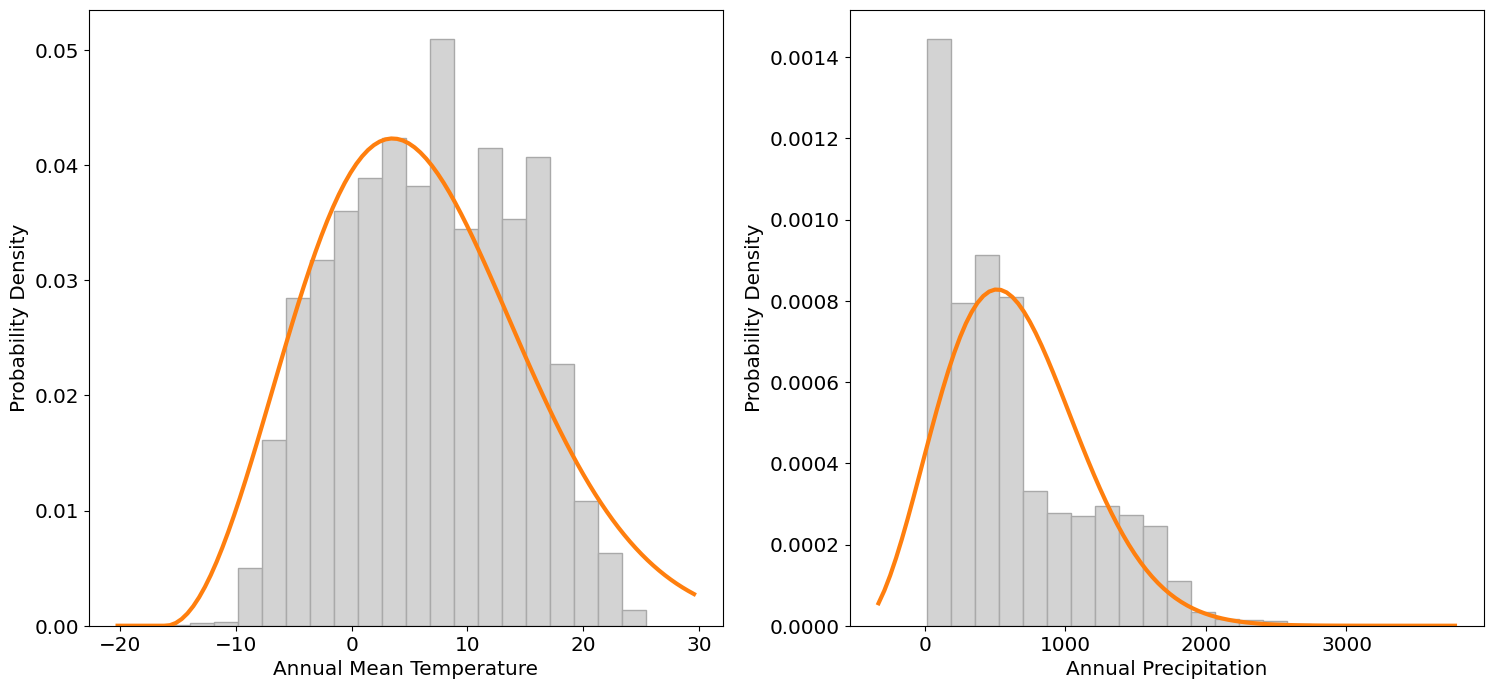

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(18,8))

background_train['bioclim_01'].plot.hist(ax=ax[0], bins=20, density=True, facecolor='lightgray', edgecolor='darkgray')
ax[0].plot(var_data['bioclim_01']['bins'], var_data['bioclim_01']['pdf'], lw=3, label='maxwell pdf')
ax[0].set_xlabel(var_data['bioclim_01']['long_name'])

background_train['bioclim_12'].plot.hist(ax=ax[1], bins=20, density=True, facecolor='lightgray', edgecolor='darkgray')
ax[1].plot(var_data['bioclim_12']['bins'], var_data['bioclim_12']['pdf'], lw=3, label='maxwell pdf')
ax[1].set_xlabel(var_data['bioclim_12']['long_name'])

for iax in ax:
    iax.set_ylabel('Probability Density')

In [10]:
if savefig:
    fig.savefig(os.path.join(figs_path, '04_pdf_bioclim-1-12_%s.png' %training), transparent=True)

In [11]:
# fig, ax = plt.subplots(ncols=1, figsize=(8,6))

# background_train['bioclim_01'].plot.hist(ax=ax, bins=20, density=True, facecolor='lightgray', edgecolor='darkgray')
# plt.plot(var_data['bioclim_01']['bins'], var_data['bioclim_01']['pdf'], lw=3, label='maxwell pdf')
# ax.set_xlabel(var_data['bioclim_01']['long_name'])
# ax.set_ylabel('Probability Density')
# fig.savefig(os.path.join(docs_path, '04_pdf_bioclim-1_%s.png' %training), transparent=True, dpi=600)

# background_train['bioclim_12'].plot.hist(ax=ax, bins=20, density=True, facecolor='lightgray', edgecolor='darkgray')
# ax.plot(var_data['bioclim_12']['bins'], var_data['bioclim_12']['pdf'], lw=3, label='maxwell pdf')
# ax.set_xlabel(var_data['bioclim_12']['long_name'])
# ax.set_ylabel('Probability Density')
# fig.savefig(os.path.join(docs_path, '04_pdf_bioclim-12.png'), transparent=True, dpi=600)


## 1.2 Probability density presence and background

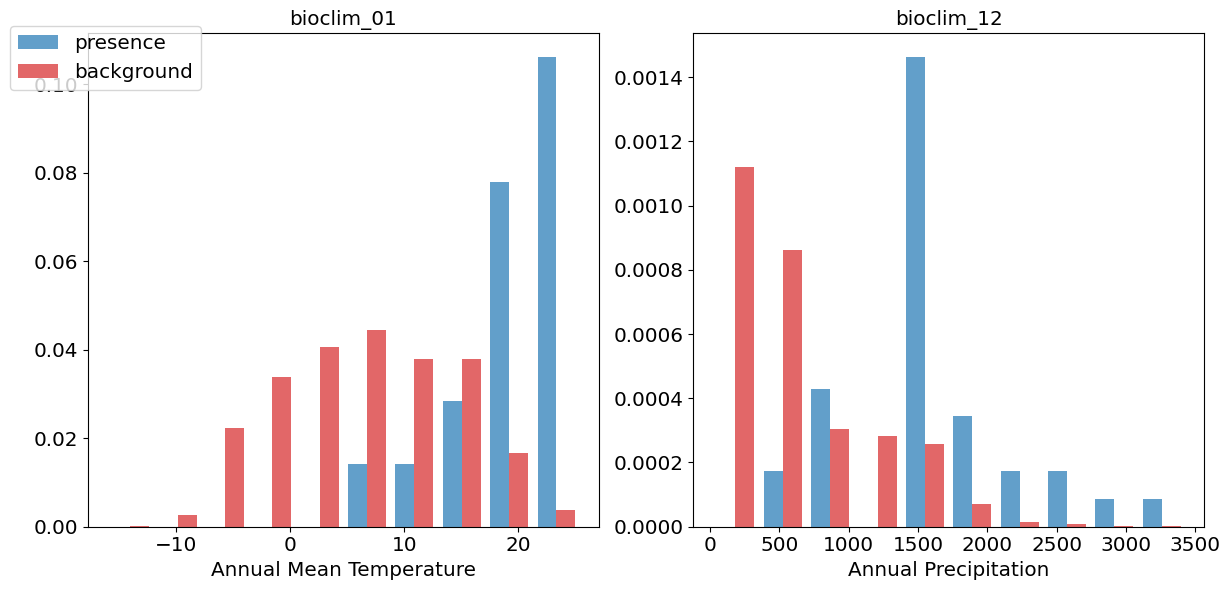

In [12]:
pair_colors = ['tab:blue', 'tab:red']
ncols, nrows = subplot_layout(len(labels))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6))
if (nrows, ncols) == (1, 1):
    ax = [axs]
else:
    ax = axs.ravel()

xlabels = list(training_data.data_vars.keys())
for iax, label in enumerate(labels):
    pvar = presence_train[label]
    
    bvar = background_train[label]
    ax[iax].hist(
        [pvar, bvar],
        density=True,
        alpha=0.7,
        label=['presence', 'background'],
        color=pair_colors,
    )
    ax[iax].set_title(label)
    try:
        ax[iax].set_xlabel(training_data[xlabels[iax]].long_name)
    except AttributeError:
        ax[iax].set_xlabel('No variable long_name')
    
handles, lbls = ax[iax].get_legend_handles_labels()
fig.legend(handles, lbls, loc='upper right', bbox_to_anchor=(0.16, 0.965))
plt.tight_layout()

# # turn off empty plots
for axi in ax:
    if not axi.title.get_text():
        axi.set_visible(False)


In [13]:
if savefig:
    fig.savefig(os.path.join(figs_path, '04_pdf_env-variables_%s.png' %training), transparent=True)

## 2. Variable correlation matrix

In [14]:
# ds = xr.merge([bioclim, srtm_region])

In [15]:
df = training_data.isel(band=0).reset_coords(['band', 'spatial_ref'], drop=True).to_dataframe()
correlation_matrix = df.corr(method='spearman')

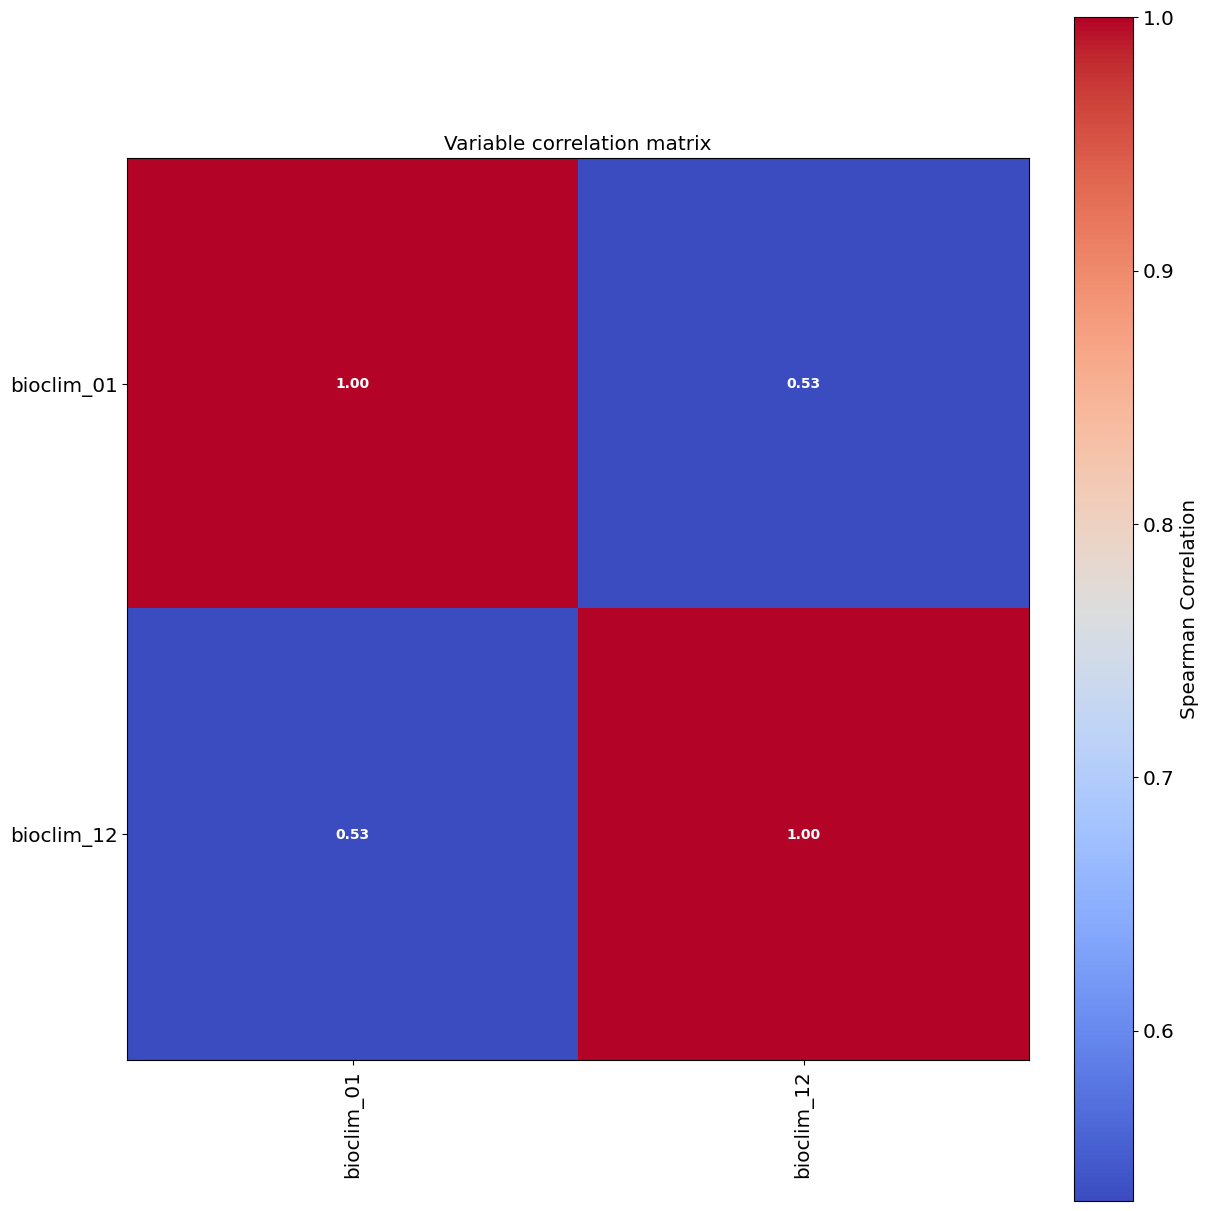

In [16]:
fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)

im = ax.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

# Display Numerical Values on Heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', color='white', weight='bold')

columns = df.columns.tolist()
ax.set_xticks(range(len(columns)), columns, rotation=90)
ax.set_yticks(range(len(columns)), columns)
ax.set_title("Variable correlation matrix")
fig.colorbar(im, label="Spearman Correlation")
# plt.savefig('correlation_heatmap_plot.png')


In [17]:
if savefig:
    fig.savefig(os.path.join(docs_path, '04_var-corr-matrix_%s.png' %training), transparent=True, bbox_inches='tight')

In [11]:
# https://github.com/osgeokr/pySDM-geemap/blob/main/pySDM-geemap_Case%20Study%201_Pitta%20nympha.ipynb
# https://github.com/dennisbakhuis/Tutorials/blob/master/3_Covariance_PCA/Principle%20component%20analysis%20and%20the%20covariance%20matrix.ipynb
# https://www.geeksforgeeks.org/exploring-correlation-in-python/